<a href="https://colab.research.google.com/github/Dinarque/INALCO_Inalco_M2_ingenierie_connaissances_2025_eleves/blob/main/TP/TP1_The_fellowship_of_the_ontology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP1 : La confrérie de l'ontologie

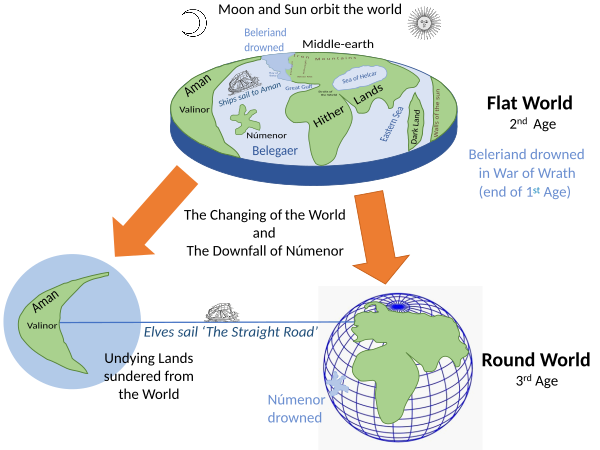

source:https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Downfall_of_N%C3%BAmenor.svg/600px-Downfall_of_N%C3%BAmenor.svg.png
(wikipedia)



L'objectif de ce TP est d'explorer les différentes méthodes d'automatisation de la constitution d'ontologies pour un domaine spécialisé.
La conception manuelle d'ontologies même avec des outils adaptés comme Protégé est fastidieuse, et en tant qu'experts en NLP, vous disposez d'une palette d'outils pour accélérer les choses !

On proposera un parcours à peu près chronologique (en terme technique) explorant différentes méthodes pour automatiser des étapes de la constitution d'une ontologie sur l'univers du Seigneur des Anneaux (Tolkien), depuis les approches purement statistiques à l'utilisation de LLMs (si on en trouve un !).

Un corpus d'environ 5000 articles issus de l'encyclopédie en ligne du seigneur des anneaux https://lotr.fandom.com/wiki/Main_Page a été sélectionné (pages informatives, normalement riches en concepts) pour plusieurs raisons:
* C'est un domaine pour lequel il n'existe pas (à ma connaissance) d'ontologie satisfaisante UPDATE : article du 14 Décembre. Il n'a pas fait d'onologie... https://medium.com/@victoralfons/the-agency-of-things-interpreting-the-lord-of-the-rings-through-object-oriented-ontology-fa538a1f2d67
* C'est un domaine peu structuré : cela vous forcera à déterminer quelles sont les méta relations essentielles pour structurer le domaine
* Ce domaine contient un vocabulaire très spécifique que ne "connaissent" pas les modèles comme BERT et forcera à se poser des questions sur l'adaptation de domaine.


Objectifs:
* Explorer différentes méthodes d'automatisation de la création d'ontologies, de la plus old school à la plus trendy
* Expérimenter et apprendre à avoir un regard critique sur le retour des algorithmes, organiser sa réflexion à partir des spécificités des données qu'on traite
* Initiation à l'adaptation à un domaine de spécialité par des méthodes comme le fine tuning
* Initiation au prompt engineering



# I) Le premier âge statistique

Dans cette partie, nous allons explorer certaines méthodes old school pour extraire les concepts et les relations du corpus.
Ces méthodes permettront de fournir le squelette de l'ontologie qu'on assemblera par la suite.

# 1) Charger et nettoyer

Le corpus vous est fourni sous la forme d'une archive de fichiers txt.
* écrivez une fonction de chargement qui renvoie une liste de str (un par fichier)
* écrivez une méthode souple qui permette de nettoyer le texte et qui soit hautement paramétrisable.
- proposez de renvoyer le texte tokenizé comme mot, comme liste de phrase ou comme texte plein
- enlevez ou non les stopwords
- enlevez ou non les majuscules.
* Donnez quelques caractéristiques sur le corpus (nombre de mots, nombre moyen de mots par article...)

Laissez les caractères spéciaux car sinon vous allez perdre les termes en langue elfique

In [1]:

import re
from typing import List, Literal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import os

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('all')

def load_corpus(folder_path: str) -> List[str]:
    """
    Charge tous les fichiers .txt d’un dossier et renvoie une liste de chaînes (un texte par fichier).
    """
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                texts.append(f.read())
    return texts


def clean_text(
    text: str,
    lowercase: bool = True,
    remove_stopwords: bool = False,
    output: Literal['text', 'tokens', 'sentences'] = 'text',
    language: str = 'french'
) -> str | List[str]:
    """
    Nettoie le texte selon les options définies :
    - lowercase : convertit en minuscules
    - remove_stopwords : enlève les stopwords
    - output : 'text' (texte brut nettoyé), 'tokens' (liste de mots), 'sentences' (liste de phrases)
    """
    if lowercase:
        text = text.lower()

    # Ne pas retirer les caractères spéciaux (langue elfique)
    text = re.sub(r'[^\w\s\-\’\'’….,;:?!]', '', text)

    if output == 'tokens':
        tokens = word_tokenize(text, language=language)
        if remove_stopwords:
            stop_words = set(stopwords.words(language))
            tokens = [t for t in tokens if t not in stop_words]
        return tokens

    elif output == 'sentences':
        return sent_tokenize(text, language=language)

    else:  # 'text'
        return text


def describe_corpus(texts: List[str]) -> None:
    """
    Affiche quelques statistiques sur le corpus.
    """
    total_words = sum(len(word_tokenize(text)) for text in texts)
    total_docs = len(texts)
    avg_words = total_words / total_docs if total_docs else 0

    print(f"Nombre de documents : {total_docs}")
    print(f"Nombre total de mots : {total_words}")
    print(f"Nombre moyen de mots par document : {avg_words:.2f}")


[nltk_data] Downloading package punkt to /Users/lydia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lydia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/lydia/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lydia/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/lydia/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/lydia/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |    

In [2]:
folder = "./lotr_corpus"
raw_texts = load_corpus(folder)
describe_corpus(raw_texts)

# Exemple de nettoyage
tokens = clean_text(raw_texts[0], lowercase=True, remove_stopwords=True, output='tokens')
sentences = clean_text(raw_texts[0], output='sentences')

Nombre de documents : 41
Nombre total de mots : 108087
Nombre moyen de mots par document : 2636.27


# 2) Les mots-clés de la Terre du milieu

* Implémentez quatre méthodes de détection de mots clés dont nous avons parlés en cours :
  * TF-IDF (avec scikit learn par exemple)
  * PMI
  * C-value / NC-value
  * Rake (via rake_nltk)

Pour les trois premières, faites en sorte qu'elles soient adaptées au repérages des n grammes avec n paramétrable.
Expliquez en language naturel le fonctionnement de l'algorithme RAKE

* Pour chaque méthode, expérimentez à partir du corpus réduit en faisant différents tests sur les paramètres de l'algorithme et de la fonction de nettoyage du texte (vaut il mieux enlever les stop words ou pas pour repérer les bi grammes? faut-il enlever la ponctuation ? ...)
Proposez un seuil pour tfidf avec des n grammes de 1, de 2 et de 3 et discutez votre choix.

BONUS : Le problème est que chaque méthode donne un classement différent.
Si on arrivait à unir les différents classements, cela permettrait d'éliminer les erreurs d'un ou autre des algos.  Implémentez vous même l'algorithme Reciprocal Rank Fusion (https://dl.acm.org/doi/10.1145/1571941.1572114) qui permet de fusionner plusieurs classements en un classement unique.
Réunissez les concepts par méthodes par nombre de n grammes et utilisez RRF pour obtenir un classement unique. Trouvez manuellement un seuil pertinent.



In [3]:
# N-gramme extraction
from collections import Counter, defaultdict
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import itertools

def extract_ngrams(texts, n, remove_stopwords=False, lowercase=True, language='french'):
    all_ngrams = []
    for text in texts:
        tokens = clean_text(text, lowercase=lowercase, remove_stopwords=remove_stopwords, output='tokens', language=language)
        all_ngrams.extend([' '.join(gram) for gram in ngrams(tokens, n)])
    return all_ngrams

def count_ngram_freqs(texts, n, remove_stopwords=False, lowercase=True, language='french'):
    freqs = Counter()
    for text in texts:
        tokens = clean_text(text, lowercase=lowercase, remove_stopwords=remove_stopwords, output='tokens', language=language)
        freqs.update([' '.join(gram) for gram in ngrams(tokens, n)])
    return freqs


In [4]:
# TFIDF
def get_tfidf_keywords(texts, ngram_range=(1,1), max_df=1.0, min_df=1):
    """
    Renvoie une liste triée de tuples (terme, score tf-idf moyen).
    Gère le cas spécial d’un seul document.
    """
    if len(texts) == 1:
        min_df = 1
        max_df = 1.0
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    return sorted(zip(vocab, tfidf_scores), key=lambda x: -x[1])



In [5]:
# PMI
def get_pmi_keywords(texts, n=2, threshold=5):
    unigram_freq = Counter()
    ngram_freq = Counter()
    total_unigrams = 0
    total_ngrams = 0

    for text in texts:
        tokens = clean_text(text, output='tokens')
        unigram_freq.update(tokens)
        total_unigrams += len(tokens)
        grams = list(ngrams(tokens, n))
        ngram_freq.update([' '.join(g) for g in grams])
        total_ngrams += len(grams)

    scores = {}
    for ng in ngram_freq:
        count_ng = ngram_freq[ng]
        if count_ng < threshold:
            continue
        parts = ng.split()
        p_ng = count_ng / total_ngrams
        p_parts = math.prod([unigram_freq[w] / total_unigrams for w in parts])
        if p_parts > 0:
            pmi = math.log2(p_ng / p_parts)
            scores[ng] = pmi

    return sorted(scores.items(), key=lambda x: -x[1])


In [6]:
# C-value
def get_cvalue_keywords(texts, n=3):
    freq = count_ngram_freqs(texts, n)
    c_values = {}
    for term, freq_term in freq.items():
        containing_terms = [t for t in freq if term in t and t != term]
        if containing_terms:
            nested_freqs = [freq[t] for t in containing_terms]
            adjusted_freq = freq_term - sum(nested_freqs) / len(nested_freqs)
        else:
            adjusted_freq = freq_term
        cval = math.log2(len(term.split()) + 1) * adjusted_freq
        c_values[term] = cval
    return sorted(c_values.items(), key=lambda x: -x[1])


In [7]:
# RAKE
from rake_nltk import Rake

def get_rake_keywords(texts, language='french'):
    rake = Rake(language=language, include_repeated_phrases=False)
    keywords = []
    for text in texts:
        rake.extract_keywords_from_text(text)
        keywords.extend(rake.get_ranked_phrases_with_scores())
    scores = defaultdict(float)
    for score, kw in keywords:
        scores[kw] += score
    return sorted(scores.items(), key=lambda x: -x[1])


In [8]:
# RRF
def reciprocal_rank_fusion(*rankings, k=60):
    """
    rankings : plusieurs listes [(term, score), ...]
    k : paramètre de pénalisation
    Retourne une liste [(term, score_RRF), ...] fusionnée.
    """
    fusion_scores = defaultdict(float)
    for ranking in rankings:
        for rank, (term, _) in enumerate(ranking):
            fusion_scores[term] += 1 / (k + rank + 1)
    return sorted(fusion_scores.items(), key=lambda x: -x[1])


In [9]:
# Wrapper
def run_keyword_extraction(
    method: Literal["tfidf", "pmi", "cvalue", "rake"],
    texts: List[str],
    n: int = 1,
    stopwords: bool = False,
    lowercase: bool = True,
    ngram_range: tuple = None
):
    if method == "tfidf":
        ngram_range = ngram_range or (n, n)
        return get_tfidf_keywords(texts, ngram_range=ngram_range)

    elif method == "pmi":
        return get_pmi_keywords(texts, n=n)

    elif method == "cvalue":
        return get_cvalue_keywords(texts, n=n)

    elif method == "rake":
        return get_rake_keywords(texts)

    else:
        raise ValueError("Méthode non reconnue.")


In [10]:
# test avec fusion RRF (notebook)

texts = load_corpus("lotr_corpus")

# 2. Appliquer chaque méthode pour les bigrammes (n=2)
keywords_tfidf = run_keyword_extraction("tfidf", texts, n=2)
keywords_pmi = run_keyword_extraction("pmi", texts, n=2)
keywords_cvalue = run_keyword_extraction("cvalue", texts, n=2)
keywords_rake = run_keyword_extraction("rake", texts)

# 3. Limiter chaque classement aux 50 premiers
top_k = 50
tfidf_top = keywords_tfidf[:top_k]
pmi_top = keywords_pmi[:top_k]
cval_top = keywords_cvalue[:top_k]
rake_top = keywords_rake[:top_k]

# 4. Fusionner avec RRF
keywords_rrf = reciprocal_rank_fusion(tfidf_top, pmi_top, cval_top, rake_top)

# 5. Afficher top 20
for i, (term, score) in enumerate(keywords_rrf[:20], 1):
    print(f"{i:>2}. {term:<30} | RRF: {score:.4f}")


 1. plus tard                      | RRF: 0.0338
 2. de la                          | RRF: 0.0328
 3. dans la                        | RRF: 0.0306
 4. seigneur des                   | RRF: 0.0299
 5. du milieu                      | RRF: 0.0292
 6. il est                         | RRF: 0.0292
 7. terre du                       | RRF: 0.0292
 8. de son                         | RRF: 0.0284
 9. dans le                        | RRF: 0.0266
10. et les                         | RRF: 0.0264
11. et de                          | RRF: 0.0261
12. le seigneur                    | RRF: 0.0261
13. de sauron                      | RRF: 0.0260
14. dans les                       | RRF: 0.0252
15. des anneaux                    | RRF: 0.0251
16. la bataille                    | RRF: 0.0249
17. la terre                       | RRF: 0.0246
18. la communauté                  | RRF: 0.0234
19. par les                        | RRF: 0.0232
20. anneau unique                  | RRF: 0.0224


In [11]:
def auto_test_tfidf(texts):
    configs = [
        {"n": 1, "min_df": 3, "stopwords": False, "label": "unigrammes – stopwords gardés"},
        {"n": 2, "min_df": 2, "stopwords": True,  "label": "bigrammes – stopwords enlevés"},
        {"n": 3, "min_df": 1, "stopwords": True,  "label": "trigrammes – stopwords enlevés"},
    ]

    for cfg in configs:
        print(f"\n🔍 TF-IDF – {cfg['label']}")
        print("-" * 50)
        cleaned = [
            clean_text(t, remove_stopwords=cfg["stopwords"], lowercase=True, output='text')
            for t in texts
        ]
        keywords = get_tfidf_keywords(
            cleaned,
            ngram_range=(cfg["n"], cfg["n"]),
            min_df=cfg["min_df"],
            max_df=0.9
        )
        for i, (term, score) in enumerate(keywords[:15], 1):
            print(f"{i:>2}. {term:<30} | TF-IDF: {score:.4f}")
        print("=" * 50)


def auto_test_pmi(texts):
    for n in [2, 3]:
        print(f"\n🔍 PMI – {n}-grammes (stopwords enlevés)")
        print("-" * 50)
        cleaned = [clean_text(t, remove_stopwords=True, lowercase=True, output='tokens') for t in texts]
        joined = [' '.join(t) for t in cleaned]
        keywords = get_pmi_keywords(joined, n=n)
        for i, (term, score) in enumerate(keywords[:15], 1):
            print(f"{i:>2}. {term:<30} | PMI: {score:.4f}")

def auto_test_cvalue(texts):
    for n in [2, 3]:
        print(f"\n🔍 C-value – {n}-grammes (stopwords enlevés)")
        print("-" * 50)
        keywords = get_cvalue_keywords(texts, n=n)
        for i, (term, score) in enumerate(keywords[:15], 1):
            print(f"{i:>2}. {term:<30} | C-value: {score:.4f}")

def auto_test_rake(texts):
    print(f"\n🔍 RAKE – Phrases-clés (stopwords enlevés)")
    print("-" * 50)
    keywords = get_rake_keywords(texts, language="french")
    for i, (term, score) in enumerate(keywords[:15], 1):
        print(f"{i:>2}. {term:<30} | RAKE: {score:.4f}")


### Exécution groupée pour 4 méthodes différentes avec différents paramètres/options de nettoyages(n-gramme, stopwords...)

In [12]:
texts = load_corpus("./lotr_corpus")

auto_test_pmi(texts)
auto_test_cvalue(texts)
auto_test_rake(texts)


🔍 PMI – 2-grammes (stopwords enlevés)
--------------------------------------------------
 1. parth galen                    | PMI: 13.6893
 2. sarn gebir                     | PMI: 13.4263
 3. araignées géantes              | PMI: 12.6893
 4. caras galadhon                 | PMI: 12.6487
 5. ouvrages articles              | PMI: 12.5518
 6. section réferences.voir        | PMI: 12.5518
 7. j. r.                          | PMI: 12.4263
 8. ajoutant références            | PMI: 12.4263
 9. cerin amroth                   | PMI: 12.4263
10. articles qualité               | PMI: 12.3108
11. tol eressëa                    | PMI: 12.3108
12. cirith ungol                   | PMI: 12.2888
13. col caradhras                  | PMI: 12.2743
14. fiables romans                 | PMI: 12.1853
15. silmarillioncontes légendes    | PMI: 12.0113

🔍 PMI – 3-grammes (stopwords enlevés)
--------------------------------------------------
 1. ouvrages articles qualité      | PMI: 24.8627
 2. j. r. r.        

In [13]:
auto_test_tfidf(texts)


🔍 TF-IDF – unigrammes – stopwords gardés
--------------------------------------------------
 1. son                            | TF-IDF: 0.1057
 2. que                            | TF-IDF: 0.1025
 3. qui                            | TF-IDF: 0.0865
 4. qu                             | TF-IDF: 0.0704
 5. anneau                         | TF-IDF: 0.0682
 6. sauron                         | TF-IDF: 0.0643
 7. the                            | TF-IDF: 0.0598
 8. gandalf                        | TF-IDF: 0.0579
 9. lui                            | TF-IDF: 0.0578
10. ils                            | TF-IDF: 0.0548
11. sa                             | TF-IDF: 0.0530
12. plus                           | TF-IDF: 0.0517
13. mais                           | TF-IDF: 0.0498
14. sur                            | TF-IDF: 0.0497
15. elle                           | TF-IDF: 0.0489

🔍 TF-IDF – bigrammes – stopwords enlevés
--------------------------------------------------
 1. qu il                         

#### TF-IDF
Bigrammes et trigrammes beaucoup plus pertinents dès qu’on enlève les stopwords ➜ ex. "terre du milieu"

#### PMI
très adapté aux entités spécifiques. Trigrammes encore plus puissants : "ouvrages articles qualité", "j. r. r."

#### C-value
Biais vers les cooccurrences fréquentes mais peu informatives en bigrammes ("de la", ", et", ". il") ➜ nécessite un filtrage manuel ou post-traitement. Très bonnes détections en trigrammes ("terre du milieu", "seigneur des anneaux"...).

#### RAKE
il extrait des phrases entières, souvent longues, utiles pour extraire des descriptions riches. Certaines clés sont mixtes (séparateurs "•", listes) ➜ peut nécessiter un post-traitement.



#### max_df & min_df

unigrammes: min_df=3 pour éliminer les mots trop rares et max_df=0.9 pour filtrer les mots trop fréquents comme les stopwords.

bigrammes: min_df=2, car les combinaisons utiles apparaissent au moins deux fois dans le corpus, et j’ai gardé max_df=0.9 pour écarter les bigrammes trop génériques.

trigrammes: j’ai conservé toutes les occurrences (min_df=1, max_df=1.0 par défaut),ces séquences sont naturellement plus rares, mais souvent très informatives.

In [14]:
def auto_test_rrf(texts, top_k=50, n=2):
    print(f"\n🔁 RRF – Fusion des classements (n={n}, top {top_k})")
    print("-" * 60)

    # Nettoyage standardisé
    cleaned = [clean_text(t, remove_stopwords=True, lowercase=True, output='text') for t in texts]

    # Méthode 1 : TF-IDF
    tfidf = get_tfidf_keywords(cleaned, ngram_range=(n, n), min_df=2)[:top_k]

    # Méthode 2 : PMI
    tokens_cleaned = [clean_text(t, remove_stopwords=True, lowercase=True, output='tokens') for t in texts]
    joined = [' '.join(t) for t in tokens_cleaned]
    pmi = get_pmi_keywords(joined, n=n)[:top_k]

    # Méthode 3 : C-value
    cval = get_cvalue_keywords(texts, n=n)[:top_k]

    # Méthode 4 : RAKE
    rake = get_rake_keywords(texts, language="french")[:top_k]

    # Fusion avec RRF
    fused = reciprocal_rank_fusion(tfidf, pmi, cval, rake)

    # Affichage top 15
    for i, (term, score) in enumerate(fused[:15], 1):
        print(f"{i:>2}. {term:<30} | RRF: {score:.4f}")

texts = load_corpus("./lotr_corpus")
auto_test_rrf(texts)



🔁 RRF – Fusion des classements (n=2, top 50)
------------------------------------------------------------
 1. plus tard                      | RRF: 0.0335
 2. de la                          | RRF: 0.0328
 3. dans la                        | RRF: 0.0306
 4. seigneur des                   | RRF: 0.0299
 5. du milieu                      | RRF: 0.0292
 6. il est                         | RRF: 0.0292
 7. terre du                       | RRF: 0.0292
 8. de son                         | RRF: 0.0284
 9. dans le                        | RRF: 0.0266
10. et les                         | RRF: 0.0266
11. et de                          | RRF: 0.0263
12. de sauron                      | RRF: 0.0256
13. le seigneur                    | RRF: 0.0256
14. dans les                       | RRF: 0.0254
15. des anneaux                    | RRF: 0.0253


# 3) Un parsing unique pour les lier tous

Le problème est que ces n grammes ne correspondent pas forcément à la réalité


* Créez une fonction filtre (simple) qui élimine les concepts inintéressants (verbes, Adverbes, mots grammaticaux) et élimine les n-grammes mal formés.

* Si les stopwords sont enlevés / passage au lowercase, le concept que vous avez découvert ne correspond pas exactement à sa forme dans les textes. Ecrivez une fonction qui repère les concepts présents dans un texte

* Créez une interface graphique streamlit pour votre application qui vous permette de tester des méthodes de détection de concepts.
Elle doit vous permettre de:
-charger un texte du corpus
- visualiser les concepts repérés dans le corpus en utilisant les méthodes
- voir les concepts surlignés dans les textes.
- avec une croix, supprimer les mauvais concepts (interface d'annotation pour rafiner les résultats statistiques)

In [ ]:
def filter_extracted_ngrams(ngrams_list: list[str], language_model="fr_core_news_sm") -> list[str]:
    """
    Garde uniquement les n-grammes informatifs : contenant au moins un nom propre ou commun,
    et ne contenant pas uniquement des stopwords ou mots grammaticaux.
    """
    nlp = spacy.load(language_model)
    filtered = []
    for ng in ngrams_list:
        doc = nlp(ng)
        if all(tok.pos_ in {"DET", "ADP", "AUX", "PRON", "CCONJ", "SCONJ", "ADV", "PART", "PUNCT"} for tok in doc):
            continue
        if all(tok.is_stop for tok in doc):
            continue
        if not any(tok.pos_ in {"NOUN", "PROPN"} for tok in doc):
            continue
        filtered.append(ng)
    return filtered

def locate_concept_in_text(text: str, concept: str, language='english') -> list[tuple[int, str]]:
    """
    Retrouve les formes brutes correspondant à un concept nettoyé dans le texte original.
    Retourne une liste de (position, extrait brut).
    """
    concept_tokens = clean_text(concept, lowercase=True, remove_stopwords=True, output='tokens', language=language)
    if not concept_tokens:
        return []

    pattern = r"\b" + r"\s+".join(map(re.escape, concept_tokens)) + r"\b"
    matches = re.finditer(pattern, text, flags=re.IGNORECASE)
    return [(m.start(), m.group()) for m in matches]


In [20]:
import spacy
# extraction de bigrammes nettoyés
texts = load_corpus("./lotr_corpus")
bigrams = extract_ngrams(texts, n=2, remove_stopwords=True, lowercase=True, language='french')

# filtrage syntaxique
filtered_bigrams = filter_extracted_ngrams(bigrams)

# Recherche du 1er concept filtré dans le 1er texte brut
matches = locate_concept_in_text(texts[0], filtered_bigrams[0])
print(f"Concept : {filtered_bigrams[0]}")
print("Occurrences :", matches)


Concept : radagast informations
Occurrences : [(0, 'Radagast Informations')]


#### Interface streamlit -> app.py + concept_detection.py


# 4) Un premier essai d'extraction des relations.

Extraire les relations est extrêmement complexe et coûteux. On a pas le temps dans ce TP de le faire de façon optimale.

On considérera pour simplifier les choses que deux concepts sont en relation quand ils apparaissent dans la même phrase. pour éviter les problèmes de combinatoire (cas de nombreuses entités) on ne retiendra que les relations entre les entités qui sont sujet de la phrase et les autres.

* Pour se faire, codez une fonction qui identifie les sujets d'une phrase.

* écrire une fonction qui prend en entrée une phrase et la liste de concepts qu'elle contient, identifie quelle.s entité.s est sujet et retourne la liste des relation entre ces entités et toutes les autres. (c'est une approximation !)

* Appliquer cette fonction au corpus pour déterminer toutes les relations. gardez trace de la relation associée à chaque phrase.

* représentez les relations de la base comme un graphe pondéré (occurrence de chaque relation)

Les relations les plus fréquentes ont de forte chance d'être les plus importantes. #


BONUS : améliorer cette méthode d'extraction des relations.


#### fichier: relations.py


#### Amélioration
1. 🔍 Améliorer la détection des concepts dans les phrases
- Actuellement : inclusion brutale (c in sentence.lower())

- Problème : faux positifs, variations morphologiques ignorées

on peut donc ytiliser un Matcher spaCy basé sur le lemma_, ou rechercher des correspondances exactes après tokenisation. Par exemple, on peut obtenir maintenant une détection de concepts beaucoup plus stable (ex : "elfes" ≈ "elfe", "royaumes" ≈ "royaume", etc.)

#II) L'avènement des Modèles

L'objectif de cette partie est d'étudier comment on peut utiliser des modèles, des plus petits aux plus grands, pour finaliser la construction de notre ontologie.
On étudiera comment les adapter à un domaine de spécialité, par prompt engineerig (LLM) ou fine-tuning sur une tâche adaptée.

# 5) Définir les méta relations / relations structurantes de l'ontologie

Une des étapes clés est de définir les méta relations qui relient les concepts. En général (sauf domaines particuliers comme la médecine) le nombre de relations structurantes d'un domaine est un inventaire restreint (quelques dizaines).

* à partir du graphe des relations construit dans la question précédente,et des textes associés, suggérez quelques méta relations pour notre ontologie sur le seigneur des anneaux.

* identifiez les verbes les plus présents dans les textes. Peut on en faire des méta relations ?

* Automatison ce procédé grâce à des LLMs !
Créez un prompt qui permette de déterminer les méta relations à partir des textes. Justifiez la manière dont vous l'avez construit et testez le.

* Finalisez une liste de 15-20 méta relations pour notre ontologie

1).
Quelques méta relations:

appartient_à (race, maison, royaume)

est_ami_de

est_ennemi_de

possède (armes, anneaux)

commande (armée, région)

vit_dans

apparaît_dans (livres, films)

combat_contre

est_parent_de

est_époux_de...

In [21]:
# extraire les verbes fréquents du corpus
import os
import spacy
from collections import Counter

nlp = spacy.load("fr_core_news_sm")

def extract_verbs_from_corpus(folder_path: str, top_k: int = 50) -> list[tuple[str, int]]:
    verb_counter = Counter()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                text = f.read()
                doc = nlp(text)
                for token in doc:
                    if token.pos_ == "VERB":
                        verb_counter[token.lemma_] += 1

    return verb_counter.most_common(top_k)



folder = "./lotr_corpus"
top_verbs = extract_verbs_from_corpus(folder)
print("🔝 Verbes les plus fréquents :")
for verb, freq in top_verbs:
    print(f"{verb} : {freq}")


🔝 Verbes les plus fréquents :
pouvoir : 230
faire : 206
avoir : 199
arriver : 139
voir : 120
prendre : 116
rendre : 115
devenir : 110
venir : 101
détruire : 97
décider : 96
tuer : 94
partir : 88
aller : 88
parvenir : 86
dire : 85
envoyer : 83
trouver : 77
mettre : 71
devoir : 70
attaquer : 68
commencer : 67
utiliser : 67
donner : 65
vouloir : 64
connaître : 63
mener : 63
être : 61
passer : 61
découvrir : 56
revenir : 56
révéler : 56
échapper : 55
retrouver : 54
savoir : 54
signifier : 54
sauver : 53
donne : 53
aider : 52
rester : 52
suivre : 50
appeler : 49
permettre : 49
apprendre : 48
accompagner : 47
apparaître : 46
capturer : 45
créer : 44
combattre : 42
diriger : 42


In [27]:
import os

input_dir = "./lotr_corpus"
output_file = "./combine.txt"

txt_files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

with open(output_file, "w", encoding="utf-8") as outfile:
    for filename in txt_files:
        file_path = os.path.join(input_dir, filename)
        with open(file_path, "r", encoding="utf-8") as infile:
            content = infile.read()
            outfile.write(f"=== Début de {filename} ===\n")
            outfile.write(content)
            outfile.write(f"\n=== Fin de {filename} ===\n\n")

Créer un corpus plus petit qui contient 10 fichiers aléatoires depuis lotr_corpus pour tourner les programmes.

In [26]:
import os
import random
import shutil

source_dir = "./lotr_corpus"
target_dir = "./lotr_corpus_small"
os.makedirs(target_dir, exist_ok=True)

# Liste des fichiers .txt
txt_files = [f for f in os.listdir(source_dir) if f.endswith(".txt")]

# Sélection aléatoire de 10 fichiers
selected = random.sample(txt_files, 10)

# Contenu concaténé
full_text = ""

for filename in selected:
    source_path = os.path.join(source_dir, filename)
    target_path = os.path.join(target_dir, filename)
    
    shutil.copy(source_path, target_path)
    
    with open(source_path, "r", encoding="utf-8") as f:
        full_text += f.read().strip() + "\n\n"

# Enregistrer le fichier concaténé
concat_path = os.path.join(target_dir, "lotr_corpus_small_concat.txt")
with open(concat_path, "w", encoding="utf-8") as f:
    f.write(full_text)

# Affichage
print(f"{len(selected)} fichiers copiés dans {target_dir} :")
for f in selected:
    print(f" - {f}")
print(f"\nContenu concaténé enregistré dans : {concat_path}")


10 fichiers copiés dans ./lotr_corpus_small :
 - Elrond.txt
 - Glorfindel.txt
 - Morgoth.txt
 - Gimli.txt
 - Barrow-wights.txt
 - Balin.txt
 - Smaug.txt
 - Shelob.txt
 - Frodon Sacquet.txt
 - Eru Ilúvatar.txt

Contenu concaténé enregistré dans : ./lotr_corpus_small/lotr_corpus_small_concat.txt


In [24]:
import os
import ollama

def extract_descriptions(folder_path: str, max_files: int = 5) -> str:
    text_blob = ""
    selected = 0
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".txt") and selected < max_files:
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                text = f.read().strip()
                text_blob += f"--- {filename.replace('.txt', '')} ---\n{text}\n\n"
                selected += 1
    return text_blob

def build_prompt_with_descriptions(descriptions: str) -> str:
    return (
        "Tu es un expert en ontologies. Tu reçois ci-dessous plusieurs descriptions encyclopédiques de personnages de l’univers du Seigneur des Anneaux.\n\n"
        "Propose exactement **15 méta-relations** (relations génériques) utilisables dans une ontologie du domaine.\n"
        "Ces relations doivent être exprimées **sous forme de labels en snake_case**, en français.\n\n"
        "Contraintes :\n"
        "- Formule-les en ** 1-3 mots max** (ex: `possede`, `combat_contre`, `est_parent_de`)\n"
        "- Réponds **uniquement** par une liste **numérotée de 15 éléments**.\n"
        "Voici les descriptions :\n\n"
        f"{descriptions}"
    )

def generate_meta_relations(folder_path: str, model: str = "llama3.2"):
    descriptions = extract_descriptions(folder_path)
    prompt = build_prompt_with_descriptions(descriptions)
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    print("Relations suggérées par le LLM :\n")
    print(response['message']['content'])

# --- Exécution ---
generate_meta_relations("./lotr_corpus_small", model="llama3.2")


Relations suggérées par le LLM :

Elrond est un personnage important dans la trilogie du Seigneur des Anneaux d'Autor de J.R.R. Tolkien. Il est le maire de Rivendel et l'un des leaders de l'alliance contre Sauron. Voici quelques informations sur Elrond :

*   Il est le fils du Vala Manwë et de la Nôtre Miriel, une Vanyar elfe.
*   Il naît en Oïton dans le royaume de Beleriand.
*   Son père meurt peu après sa naissance et il est élevé par son frère aîné, Durin, qui est un Elfain à sa peau. 
*   Sa mère reste en Valinor avec ses sœurs où elle devient la reine des Noldo.
*   Il rencontre Galadriel et se marie avec elle. Leur mariage dure 1 000 ans et ils sont toujours très proches dans l'alliance contre Sauron.
*   Il est le grand-père de Elros, le premier Roi de Gondor.
*   Il reçoit Nenya lorsqu'Adar prend Galadriel et les deux lui prennent à son tour mais reviennent ensuite sur ses actes.


Je n'ai pas réussi avec le LLM local, donc au final j'ai directement utilisé chatgpt en ligne pour générer les 15 méta-relations depuis notre corpus. Voici sa réponse:

est_parent_de

est_enfant_de

combat_contre

est_allie_de

porte_objet

appartient_a_race

a_titre

regne_sur

fait_partie_de

est_ami_de

traque

est_ennemi_de

se_marie_avec

sacrifie_pour

est_mentor_de

3).
un prompt qui détermine les méta relations à partir des textes -> `label_triplets.py`

à partir du fichier `relations_triplets.csv` généré par `relation.py` qui contient des colonnes comme `entity1`, `entity2`, `sentence`, on demande au llm de choisir une des méta-relations données pour relier les 2 entités en fonction de `sentence`

# 6) Fine tuner BERT pour la classification de relations

Vous avez dans la question 5 délimité la quinzaine de relations essentielles de notre ontologie.

* Utilisez un LLM pour faire de la classification de relations sur notre corpus.
Lancez ce prompt sur quelques fichiers pour obtenir un corpus d'entraînement décent (quelques centaines de phrases).
Assurez vous que toutes les catégories sont bien représentées dans le corpus d'entraînement.

* Fine tunez le modèle Bilbert que j'ai créé pour vous sur ce corpus sur la tâche de classification de relations en faisant un train / test split sur le corpus généré automatiquement

* évaluez à la main son résultat sur de nouveaux exemples. Cela vous semble-t-il bon ?

BONUS : si vous avez les ressources: fine tunez, à hyperparamètres égaux, l'ancien BERT et Modern BERT sur cette même tâche de classification et comparez les résultats des trois modèles.
Concluez si le fine tuning sur un corpus de spécialité est une étape nécessaire.

`labeled_triplets.csv` est généré avec 100 phrases contenant entity1, entity2, sentence ainsi que leurs labels(relation)

# 7) Exploration de d'autres méthodes de classification des relations.

Fine Tuner BERT deux fois était très amusant, mais c'est peut être beaucoup d'efforts pour pas grand chose. On va tenter d'obtenir des résultats semblables avec des méthodes moins couteuses:

* Un substitut à la classification : la similarité sémantique.

écrivez pour chaque méta relation une phrase canonique illustrant le mieux cette relation.
par exemple "Minas Tirith se trouve dans le Gondor" pour illustrer la relation is_located_in.

Isolez dans vos phrases les segments minimaux contenant les deux concepts en relation.
Puis trouvez la phrase représentant une méta relation à laquelle la phrase est la plus similaire.
Utilisez cette approche pour classifier vos relations.
On peut parler de pseudo classification

1) phrases canoniques pour chaque méta-relation:

| Méta-relation           | Phrase canonique                                                     |
| ----------------------- | -------------------------------------------------------------------- |
| **est\_parent\_de**     | *Thranduil est le père de Legolas, prince de la Forêt Noire.*        |
| **est\_enfant\_de**     | *Elendil est le fils d’Amandil, dernier seigneur de Númenor.*        |
| **combat\_contre**      | *Gandalf combat contre le Balrog dans les profondeurs de la Moria.*  |
| **est\_allie\_de**      | *Le Rohan est allié au Gondor dans la guerre contre Sauron.*         |
| **porte\_objet**        | *Frodon porte l’Anneau Unique jusqu’à la Montagne du Destin.*        |
| **appartient\_a\_race** | *Gimli appartient à la race des Nains, tout comme son père Glóin.*   |
| **a\_titre**            | *Gandalf porte le titre de Magicien Gris parmi les peuples libres.*  |
| **regne\_sur**          | *Aragorn règne sur le Gondor après la chute du Mordor.*              |
| **fait\_partie\_de**    | *Frodon fait partie de la Communauté de l’Anneau depuis Fondcombe.*  |
| **est\_ami\_de**        | *Legolas est l’ami fidèle de Gimli, malgré leurs différences.*       |
| **traque**              | *Les Nazgûl traquent Frodon dans leur quête de l’Anneau.*            |
| **est\_ennemi\_de**     | *Sauron est l’ennemi juré des peuples libres de la Terre du Milieu.* |
| **se\_marie\_avec**     | *Aragorn se marie avec Arwen après la guerre de l’Anneau.*           |
| **sacrifie\_pour**      | *Boromir se sacrifie pour sauver Merry et Pippin des Uruk-hai.*      |
| **est\_mentor\_de**     | *Gandalf est le mentor de Frodon dans sa quête vers le Mordor.*      |


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Méta-relations et phrases canoniques
canonical_examples = {
    "est_parent_de": "Thranduil est le père de Legolas, prince de la Forêt Noire.",
    "est_enfant_de": "Elendil est le fils d’Amandil, dernier seigneur de Númenor.",
    "combat_contre": "Gandalf combat contre le Balrog dans les profondeurs de la Moria.",
    "est_allie_de": "Le Rohan est allié au Gondor dans la guerre contre Sauron.",
    "porte_objet": "Frodon porte l’Anneau Unique jusqu’à la Montagne du Destin.",
    "appartient_a_race": "Gimli appartient à la race des Nains, tout comme son père Glóin.",
    "a_titre": "Gandalf porte le titre de Magicien Gris parmi les peuples libres.",
    "regne_sur": "Aragorn règne sur le Gondor après la chute du Mordor.",
    "fait_partie_de": "Frodon fait partie de la Communauté de l’Anneau depuis Fondcombe.",
    "est_ami_de": "Legolas est l’ami fidèle de Gimli, malgré leurs différences.",
    "traque": "Les Nazgûl traquent Frodon dans leur quête de l’Anneau.",
    "est_ennemi_de": "Sauron est l’ennemi juré des peuples libres de la Terre du Milieu.",
    "se_marie_avec": "Aragorn se marie avec Arwen après la guerre de l’Anneau.",
    "sacrifie_pour": "Boromir se sacrifie pour sauver Merry et Pippin des Uruk-hai.",
    "est_mentor_de": "Gandalf est le mentor de Frodon dans sa quête vers le Mordor."
}

canon_df = pd.DataFrame([
    {"label": label, "canonical": phrase}
    for label, phrase in canonical_examples.items()
])

# Charger le modèle
model = SentenceTransformer("all-MiniLM-L6-v2")
canon_embeddings = model.encode(canon_df["canonical"].tolist(), convert_to_tensor=True)

# Charger les relations
df = pd.read_csv("labeled_triplets.csv")

def extract_segment(sentence, e1, e2):
    e1_idx = sentence.lower().find(e1.lower())
    e2_idx = sentence.lower().find(e2.lower())
    if e1_idx == -1 or e2_idx == -1:
        return sentence
    start = min(e1_idx, e2_idx)
    end = max(e1_idx + len(e1), e2_idx + len(e2))
    return sentence[start:end]

# Appliquer la pseudo-classification
segments = []
pseudo_labels = []

for _, row in df.iterrows():
    seg = extract_segment(row["sentence"], row["entity1"], row["entity2"])
    segments.append(seg)

    emb = model.encode(seg, convert_to_tensor=True)
    scores = util.cos_sim(emb, canon_embeddings)[0]
    best_idx = scores.argmax().item()
    pseudo_labels.append(canon_df.iloc[best_idx]["label"])

df["segment"] = segments
df["pseudo_label"] = pseudo_labels

df.to_csv("relations_pseudo_classifiees.csv", index=False)
print("Fichier : relations_pseudo_classifiees.csv généré.")


Fichier : relations_pseudo_classifiees.csv généré.


* Utilisez un algorithme de clustering sur les phrases contenant les relations. Les relations que vous avez annotées appartiennent-elles toutes au même cluster ? Si oui attribuez par contagion l'étiquette d'une relation à tout le cluster.

* évaluez vos résultats.


Résultats: `relations_clusterisees.csv`

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

df = pd.read_csv("relations_clusterisees.csv")

accuracy = accuracy_score(df["label"], df["contagion_label"])
print(f"Précision globale (contagion) : {accuracy:.3f} ({accuracy*100:.1f}%)")

# Tableau croisé : pour voir la répartition des labels par cluster
print("\nTableau croisé cluster vs. label :\n")
print(pd.crosstab(df["cluster"], df["label"]))

# Homogénéité par cluster : pour chaque cluster, pourcentage d'éléments avec le label dominant
print("\nDétail par cluster (homogénéité) :")
for cid in sorted(df["cluster"].unique()):
    cluster_labels = df[df["cluster"] == cid]["label"]
    dominant_label = cluster_labels.mode().iloc[0]
    pct = (cluster_labels == dominant_label).mean()
    print(f" - Cluster {cid:>2} | taille = {len(cluster_labels):>3} | dominant = {dominant_label:20} | homogénéité = {pct*100:.1f}%")


Précision globale (contagion) : 0.490 (49.0%)

Tableau croisé cluster vs. label :

label    a_titre  appartient_a_race  combat_contre  est_allie_de  est_ami_de  \
cluster                                                                        
0              0                  1              4             0           0   
1              0                  8              1             0           3   
2              0                  1              0             0           0   
3              1                  5              2             3           0   
4              0                  0              0             0           0   
5              1                 10              6             0           2   
6              0                  4              3             0           0   
7              0                  2              2             0           0   
8              0                  1              0             0           0   
9              2                  0  

- Le clustering par similarité sémantique permet donc de retrouver environ la moitié(49%) des relations correctement sans supervision directe.
- Certaines relations dominent sémantiquement : `fait_partie_de` est très présente et tend à capturer des phrases variées.
- Les relations plus précises (`est_ami_de`, `traque`, `porte_objet`) sont souvent diluées dans des clusters majoritairement `fait_partie_de`




* Selon vous, ces méthodes sont elles viables pour classifier les relations ? Pourquoi ? Si besoin que pourrait on faire pour améliorer ?

Non, pas viables de manière autonome. est_allie_de vs est_ami_de ou est_parent_de vs est_mentor_de sont souvent dans les mêmes clusters -> confusion de différents clusters

Relation dominante absorbe les autres: fait_partie_de devient un "fourre-tout" → regroupe à tort des relations qui coexistent dans la même structure syntaxique.


#### Améliorations:
 Regrouper d’abord par des heuristiques (entités humaines, lieux, objets...) pour réduire l’ambiguïté

## 8 La hiérarchie des concepts

* Utilisez un modèle pour obtenir un embedding des concepts identifiés.

* Construisez une heatmap représentant la similarité sémantique entre les concepts.

267 concepts uniques


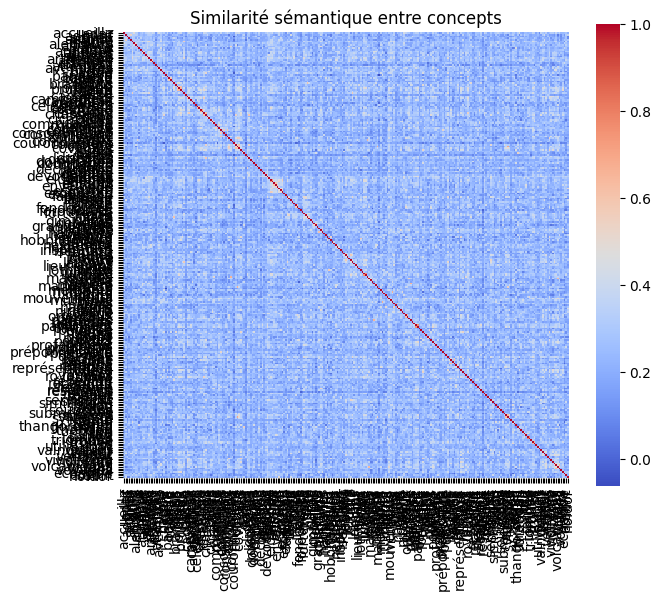

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util


df = pd.read_csv("./labeled_triplets.csv")
concepts = sorted(set(df["entity1"].tolist() + df["entity2"].tolist()))
print(f"{len(concepts)} concepts uniques")

# Encoder les concepts
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(concepts, convert_to_tensor=True)

# Matrice de similarité cosinus
sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

# heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(sim_matrix, xticklabels=concepts, yticklabels=concepts, cmap="coolwarm", square=True, cbar=True)
plt.title("Similarité sémantique entre concepts")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig("heatmap_concepts.png", dpi=300)
plt.show()


* Utilisez des techniques de clustering hiérarchiques pour obtenir un dendogramme / arbre représentant leurs relations sémantiques.

* Exploitez cette représentation pour déterminer automatiquement les concepts synonymes / ceux qui sont méronymes.


Commentez les résultats.

BONUS : intégrez tous ces résultats et avancées dans l'outil de visualisation.

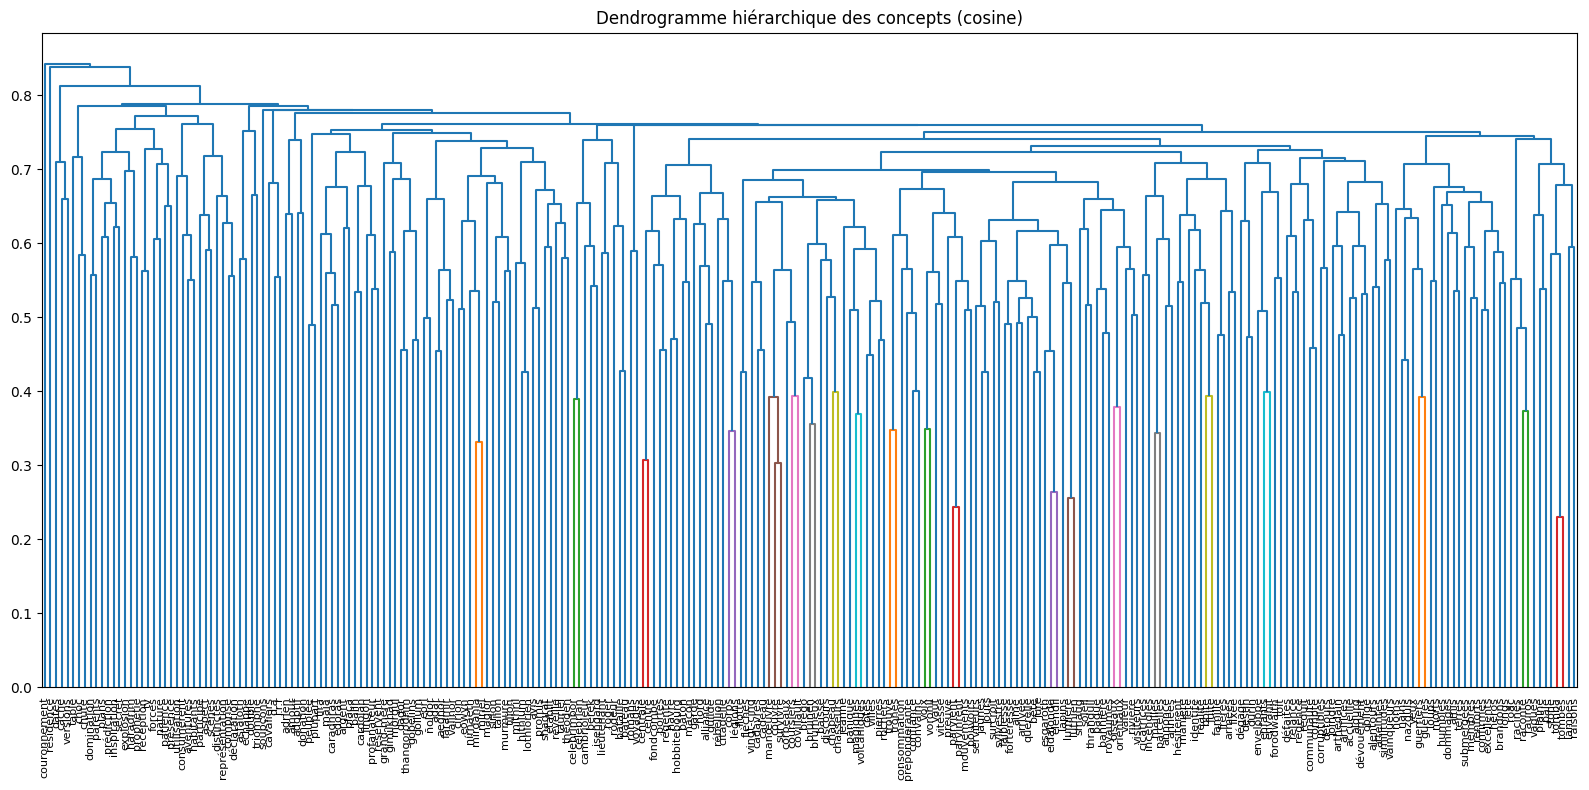

Groupes de concepts similaires :

- Cluster 180: ['boîte', 'fuite']
- Cluster 123: ['bruinen', 'brumeux']
- Cluster 89: ['celebrimbor', 'celebrían']
- Cluster 100: ['centrale', 'centre']
- Cluster 125: ['chapeau', 'chasseurs']
- Cluster 112: ['corps', 'légions']
- Cluster 121: ['coursiers', 'covillault']
- Cluster 120: ['couvre', 'manœuvre', 'survivre']
- Cluster 159: ['eldalondë', 'elendil']
- Cluster 191: ['enfants', 'envahit']
- Cluster 216: ['guerriers', 'guéries']
- Cluster 161: ['lumière', 'luthien']
- Cluster 128: ['magiques', 'volcaniques']
- Cluster 175: ['mailles', 'parcelles']
- Cluster 72: ['mirdania', 'míriel']
- Cluster 169: ['oiseaux', 'orientaux']
- Cluster 143: ['parvient', 'parvinrent']
- Cluster 233: ['raconté', 'rauros']
- Cluster 239: ['tomba', 'tombés']
- Cluster 135: ['trouve', 'trônes']
- Cluster 140: ['voix', 'vorohil']


In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("labeled_triplets.csv")
concepts = sorted(set(df["entity1"].tolist() + df["entity2"].tolist()))

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(concepts)

# Clustering hiérarchique (méthode average linkage)
Z = linkage(embeddings, method='average', metric='cosine')

# Tracer le dendrogramme
plt.figure(figsize=(16, 8))
dendrogram(Z, labels=concepts, leaf_rotation=90, leaf_font_size=8, color_threshold=0.4)
plt.title("Dendrogramme hiérarchique des concepts (cosine)")
plt.tight_layout()
# plt.savefig("dendrogramme_concepts.png", dpi=300)
plt.show()

# Identifier les groupes proches (synonymes / méronymes potentiels)
# seuil à ajuster selon le niveau de regroupement
threshold = 0.4
clusters = fcluster(Z, t=threshold, criterion='distance')

# regroupement de concepts par cluster
from collections import defaultdict
cluster_map = defaultdict(list)
for concept, cluster_id in zip(concepts, clusters):
    cluster_map[cluster_id].append(concept)

# les clusters contenant au moins 2 concepts
print("Groupes de concepts similaires :\n")
for cid, group in cluster_map.items():
    if len(group) > 1:
        print(f"- Cluster {cid}: {group}")


# III)  Conbat et conquête



# 9) OLAF

* Installez l'environnement d'OLAF

* Faites plusieurs expériences avec la librairie sur le corpus.

Quels composants donnent selon vous les meilleurs résultats ?

* Quelles sont les principales différences que vous constatez entre ces résultats et les notres ?  Si vous avez le courage codez de quoi voir quantitativement ces différences (plus facile après la question 10 )

In [ ]:
from olaf.io.loader import load_txt_corpus
from olaf.extractors import CValueExtractor
from olaf.filters import StopwordFilter
from olaf.pipelines import ConceptPipeline

corpus = load_txt_corpus("./lotr_corpus")

pipeline = ConceptPipeline(
    extractors=[CValueExtractor()],
    filters=[StopwordFilter(language="fr")]
)

concepts = pipeline.fit_transform(corpus)
for c in concepts[:20]:
    print(c.text, "→", c.score)


Je n'ai pas réussi à installer OLAF malheureusement...

# 10) La fin de l'interface

Complétez votre interface en:
* ajoutez les boutons pour effectuer toutes les nouvelles opératios (tri de concepts, de relations...). Faites en sorte que ces informations soient stockées dans des structures de données adaptées.

* Proposant un bouton qui permette l'export de votre ontologie au format owl ou rtf

* Proposant une option pour visualiser votre ontologie (je recommande pyviz par exemple)


BONUS : donnez à l'utilisateur de votre plateforme des informations sur le temps de traitemnet / là ou ça en est quand il lance des opérations longues.

Voir dans `app.py`

# Un modèle pour les embedder tous
https://huggingface.co/datasets/jeremyarancio/lotr-book
